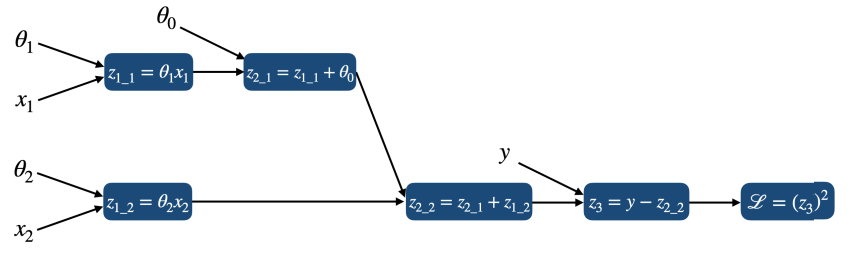

# Dataset Preparation

In [1]:
# basic_nodes
class plus_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None
      
  def forward(self,x,y):
    self._x, self._y = x, y
    self._z = self._x + self._y
    return self._z
  
  def backward(self, dz): # dz = dJ/dz
    return dz*1,dz*1 #dJ/dx= dJ/dz * dz/dx, dJ/dy

class minus_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None

  def forward(self, x, y):
    self._x, self._y = x, y
    self._z = self._x - self._y
    return self._z

  def backward(self, dz):
    return 1*dz, -1*dz

class mul_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None

  def forward(self, x, y):
    self._x , self._y = x, y
    self._z = self._x * self._y
    return self._z

  def backward(self, dz):
    return dz*self._y, dz*self._x # dJ/dz * dz/dx, dJ/dy

class square_node:
  def __init__(self):
    self._x = None
    self._z = None

  def forward(self, x):
    self._x = x
    self._z = self._x * self._x
    return self._z

  def backward(self, dz):
    return dz*(2*self._x)

class mean_node:
  def __init__(self):
    self._x = None
    self._z = None

  def forward(self, x):
    self._x = x
    self._z = np.mean(self._x) # z = 1/n *(x1+x2+...+xn)
    return self._z

  def backward(self, dz):
    dx = dz*1/len(self._x)*np.ones_like(self._x) # dJ/dx1 = dJ/dz * dz/dx1 = dJ/dz * (1/n)
    return dx

In [2]:
class dataset_generator:
    def __init__(self, feature_dim, n_sample = 100, noise = 0):
        self._feature_dim = feature_dim
        self._n_sample = n_sample
        self._noise = noise
        
        self._coefficient_list = None
        self._distribution_params = None
        
        self._dataset = None
        
        self._init_coefficient()
        self._init_distribution_params()
        
    def _init_coefficient(self):
        self._coefficient_list = [0] + [1 for _ in range(self._feature_dim)]
        
    def _init_distribution_params(self):
        self._distribution_params = {f:{'mean':0, 'std':1}
                                     for f in range(1, self._feature_dim+1)}
    
    def make_dataset(self):
        x_data = np.zeros(shape = (self._n_sample, 1))
        y_data = np.zeros(shape = (self._n_sample, 1))
        
        for f_idx in range(1, self._feature_dim + 1):
            feature_data = np.random.normal(loc = self._distribution_params[f_idx]['mean'],
                                            scale = self._distribution_params[f_idx]['std'],
                                            size = (self._n_sample, 1))
            x_data = np.hstack((x_data, feature_data))
            
            y_data += self._coefficient_list[f_idx]*feature_data
        y_data += self._coefficient_list[0]
        
        return x_data, y_data

    def set_n_sample(self, n_sample):
        self._n_sample = n_sample
    
    def set_noise(self, noise):
        self._noise = noise
    
    def set_distribution_params(self, distribution_params):
        for param_key, param_value in distribution_params.items():
            self._distribution_params[param_key] = param_value
    
    def set_coefficient(self, coefficient_list):
        self._coefficient_list = coefficient_list

# Learning Prepartion

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.style.use('seaborn')
np.random.seed(0)

def get_data_batch(data, batch_idx):
  if batch_idx is (n_batch -1):
    batch = data[batch_idx*batch_size:]
  else:
    batch = data[batch_idx*batch_size : (batch_idx+1)*batch_size]
  return batch

feature_dim = 2
batch_size = 8

data_gen = dataset_generator(feature_dim= feature_dim)
x_data, y_data = data_gen.make_dataset()

data = np.hstack((x_data, y_data))
n_batch = np.ceil(data.shape[0]/batch_size).astype(int)

Th = np.random.normal(0,1, size=(feature_dim+1)).reshape(-1,1)
epochs, lr = 100, 0.001

th_accum = Th.reshape(-1,1)
cost_list = []

# model implementation
node1 = [None] + [mul_node() for _ in range(feature_dim)]
node2 = [None] + [plus_node() for _ in range(feature_dim)]

# cost implementation
node3 = minus_node()
node4 = square_node()
node5 = mean_node()

# Learning

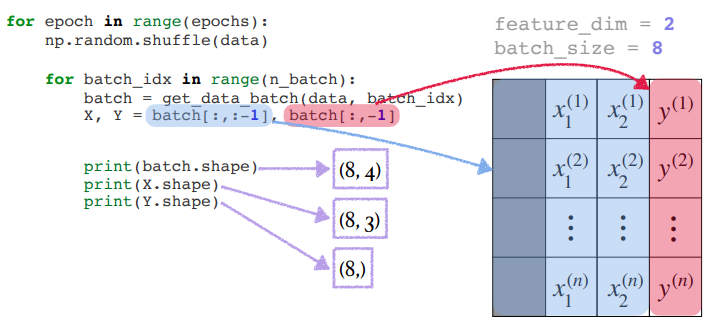

In [6]:
for epoch in range(epochs):
  np.random.shuffle(data)

  # batch extraction
  for batch_idx in range(n_batch):
    batch = get_data_batch(data, batch_idx)
    X, Y = batch[:,:-1], batch[:,-1]

  # forward propagation
  Z1_1 = node1[1].forward(Th[1], X[:,1])
  Z1_2 = node1[2].forward(Th[2], X[:,2])
  Z2_1 = node2[1].forward(Th[0], Z1_1)
  Z2_2 = node2[2].forward(Z2_1, Z1_2)

  Z3 = node3.forward(Y, Z2_2)
  Z4 = node4.forward(Z3)
  J = node5.forward(Z4)

  # backpropagation
  dZ4 = node5.backward(1)
  dZ3 = node4.backward(dZ4)
  _, dZ2_2 = node3.backward(dZ3)

  dZ2_1, dZ1_2 = node2[2].backward(dZ2_2)
  dTh0, dZ1_1 = node2[1].backward(dZ2_1)
  dTh2, _ = node1[2].backward(dZ1_2)
  dTh1, _ = node1[1].backward(dZ1_1)

  # parameter update
  Th[2] = Th[2] - lr*np.sum(dTh2)
  Th[1] = Th[1] - lr*np.sum(dTh1)
  Th[0] = Th[0] - lr*np.sum(dTh0)

  th_current = Th.reshape(-1,1)
  th_accum = np.hstack((th_accum, th_current))
  cost_list.append(J)

# for M samples

## Affine Function Class

In [7]:
class Affine_Function:
  def __init__(self, feature_dim, Th):
    self._feature_dim = feature_dim
    self._Th = Th

    self._Z1_list = [None]*(self._feature_dim + 1)
    self._Z2_list = self._Z1_list.copy()
    self._dZ1_list, self._dZ2_list = self._Z1_list.copy(),  self._Z1_list.copy()
    self._dTh_list =  self._Z1_list.copy()

    self.affine_imp()

  def affine_imp(self):
    self._node1 = [None] + [mul_node() for _ in range(self._feature_dim)]
    self._node2 = [None] + [plus_node() for _ in range(self._feature_dim)]

  def forward(self, X):
    for node_idx in range(1, self._feature_dim+1):
      self._Z1_list[node_idx] = self._node1[node_idx].forward(self._Th[node_idx], X[:,node_idx])
    
    self._Z2_list[1] = self._node2[1].forward(self._Th[0], self._Z1_list[1])
    for node_idx in range(2, feature_dim+1):
      self._Z2_list[node_idx] = self._node2[node_idx].forward(self._Z2_list[node_idx-1], self._Z1_list[node_idx])
    return self._Z2_list[-1]

  def backward(self, dZ2_last, lr):
    self._dZ2_list[-1] = dZ2_last

    for node_idx in reversed(range(1, self._feature_dim + 1)):
      dZ2, dZ1 = self._node2[node_idx].backward(self._dZ2_list[node_idx])
      self._dZ2_list[node_idx-1] = dZ2
      self._dZ1_list[node_idx] = dZ1

    self._dTh_list[0] = self._dZ2_list[0]
    for node_idx in reversed(range(1, self._feature_dim + 1)):
      dTh, _ = self._node1[node_idx].backward(self._dZ1_list[node_idx])
      self._dTh_list[node_idx] = dTh

    for th_idx in range(self._Th.shape[0]):
      self._Th[th_idx] = self._Th[th_idx] - lr*np.sum(self._dTh_list[th_idx])

    return self._Th

## MSE Cost Class

In [8]:
class MSE_Cost:
  def __init__(self):
    self.cost_imp()

  def cost_imp(self):
    self._node3 = minus_node()
    self._node4 = square_node()
    self._node5 = mean_node()

  def forward(self, Y, Pred):
    Z3 = self._node3.forward(Y, Pred)
    Z4 = self._node4.forward(Z3)
    J = self._node5.forward(Z4)
    return J

  def backward(self):
    dZ4 = self._node5.backward(1)
    dZ3 = self._node4.backward(dZ4)
    _, dZ2_last = self._node3.backward(dZ3)
    return dZ2_last

## Learning Code

In [9]:
affine = Affine_Function(feature_dim, Th)
cost = MSE_Cost()

for epoch in range(epochs):
  np.random.shuffle(data)

  for batch_idx in range(n_batch):
    batch = get_data_batch(data, batch_idx)
    X, Y = batch[:,:-1], batch[:,-1]

    # forward
    Pred = affine.forward(X)
    J = cost.forward(Y,Pred)

    # backpropagation
    dPred = cost.backward()
    affine.backward(dPred, lr)

    # parameter update
    th_accum = np.hstack((th_accum, affine._Th))
    cost_list.append(J)

# Learning with Irrelevant Features

In [10]:
feature_dim, n_sample = 3, 300

data_gen = dataset_generator(feature_dim = feature_dim, n_sample= n_sample)
x_data, y_data = data_gen.make_dataset()

for _ in range(3):
  noise_data = np.random.normal(0,1, size=(n_sample,1))
  x_data = np.hstack((x_data, noise_data))
data = np.hstack((x_data, y_data))

In [11]:
print(x_data.shape) # 첫번째 컬럼은 빈 껍데기
print(y_data.shape)
print(data.shape)

(300, 7)
(300, 1)
(300, 8)


In [13]:
feature_dim = x_data.shape[1] - 1
batch_size = 8

n_batch = np.ceil(data.shape[0]/batch_size).astype(int)
Th = np.random.normal(0, 1, size=(feature_dim+1)).reshape(-1,1)

th_accum = Th.reshape(-1,1)
cost_list = []

affine = Affine_Function(feature_dim, Th)
cost = MSE_Cost()

print(len(affine._node1))

7


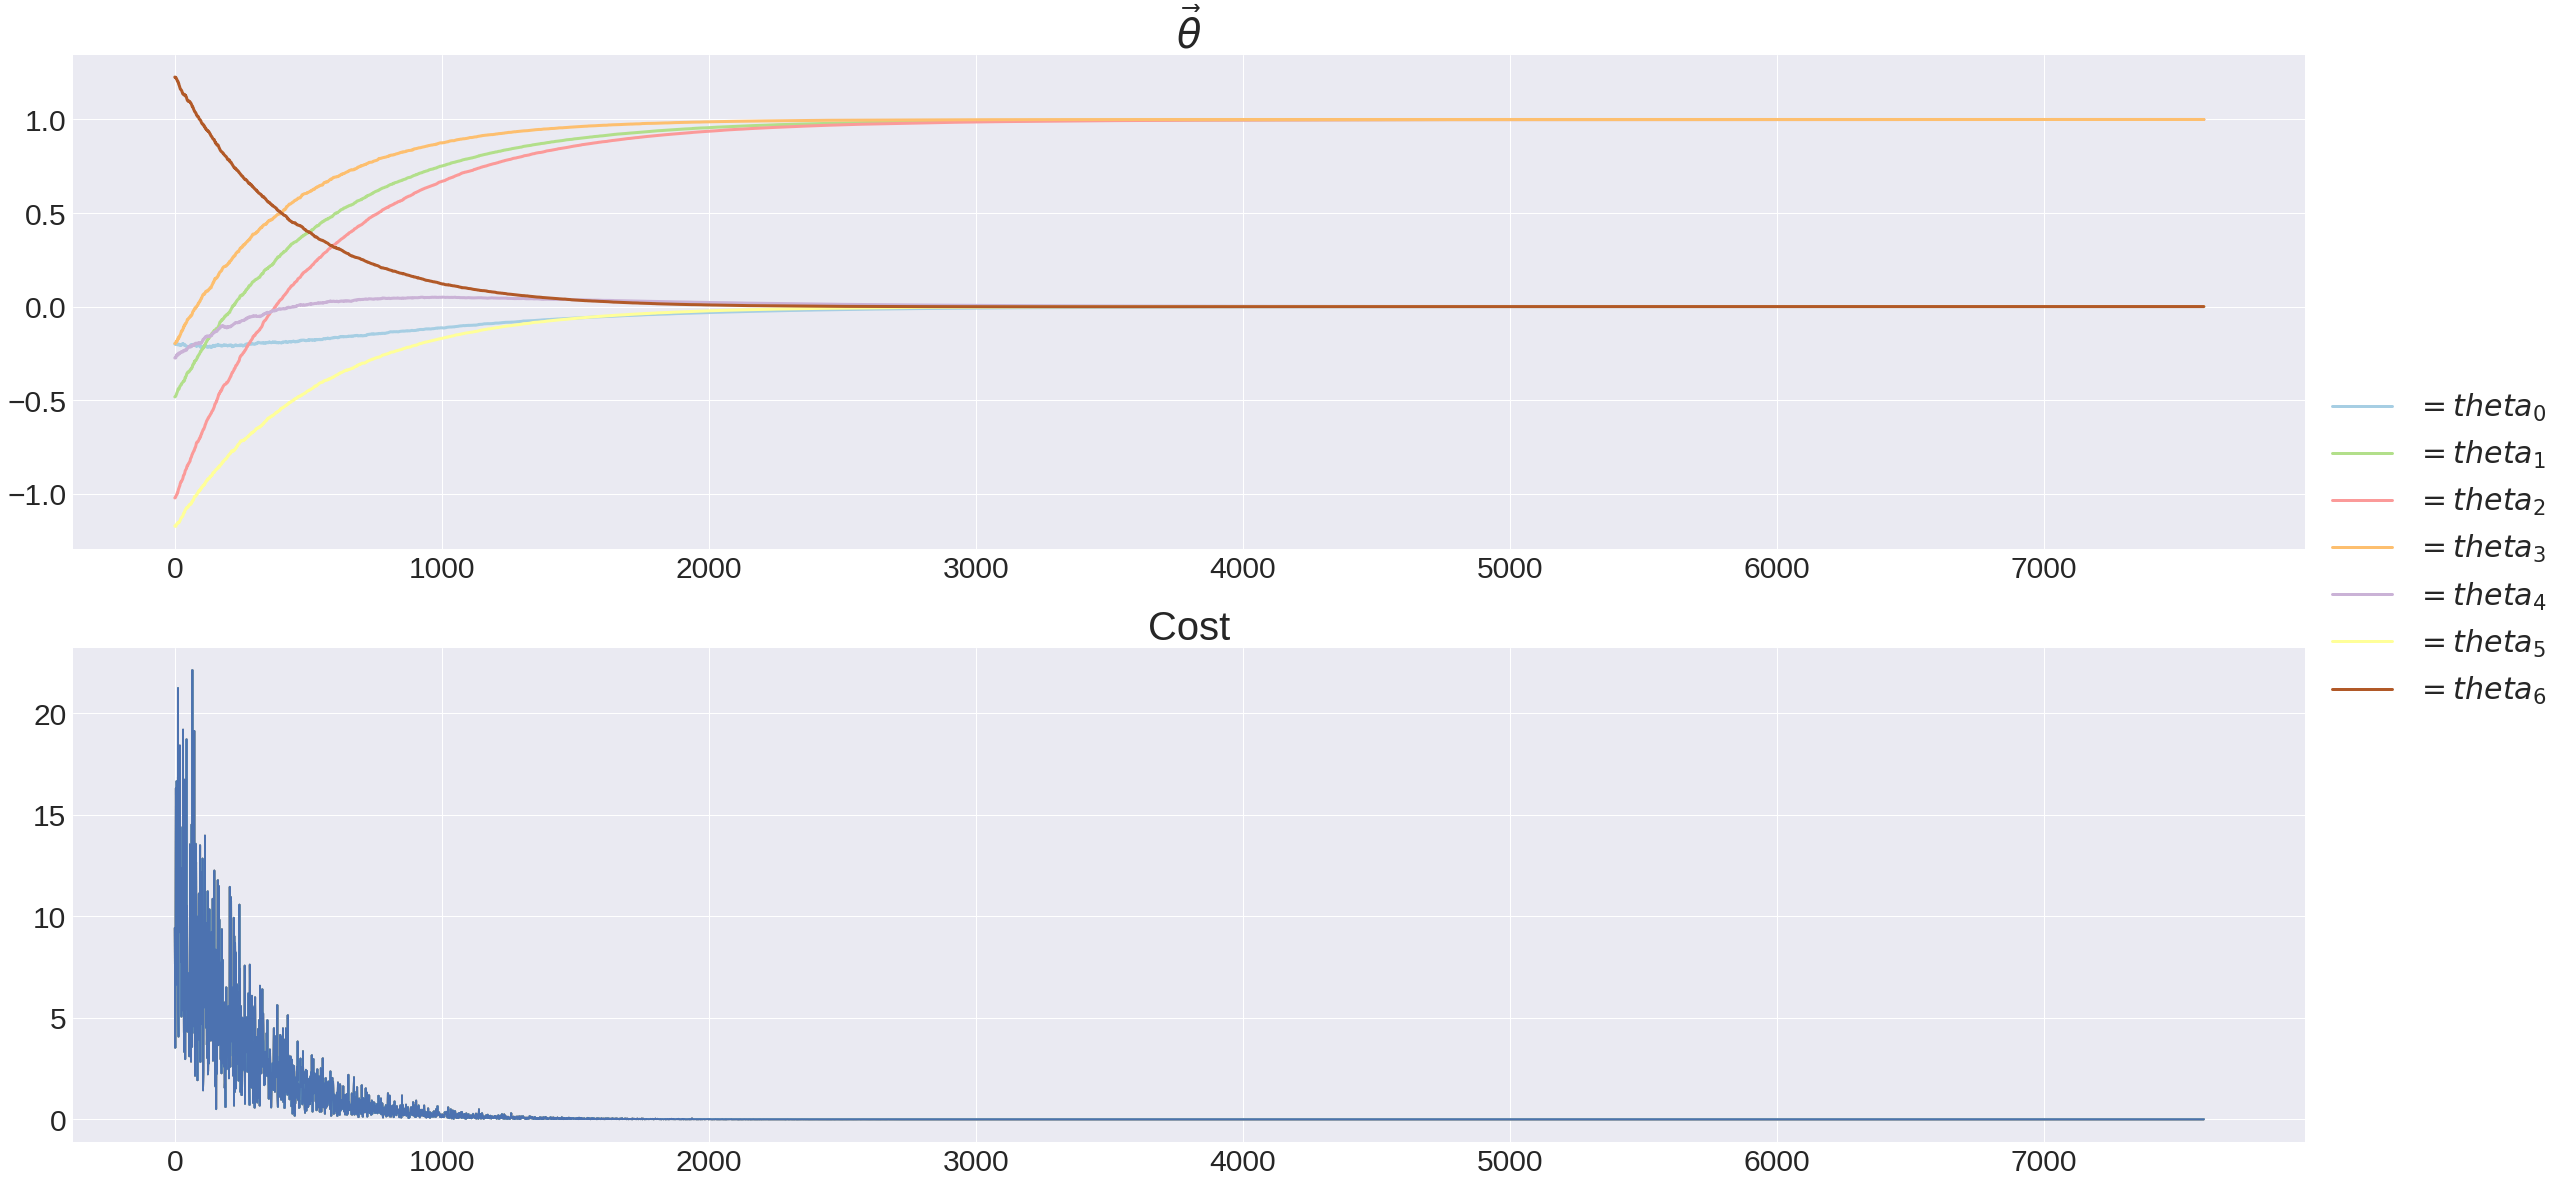

In [15]:
for epoch in range(epochs):
  np.random.shuffle(data)

  for batch_idx in range(n_batch):
    batch = get_data_batch(data, batch_idx)
    X, Y = batch[:,:-1], batch[:,-1]

    Pred = affine.forward(X)
    J = cost.forward(Y,Pred)

    dPred = cost.backward()
    affine.backward(dPred, lr)

    th_accum = np.hstack((th_accum, affine._Th))
    cost_list.append(J)

# visualization
fig,ax = plt.subplots(2,1, figsize=(40,20))
cmap = cm.get_cmap('Paired', lut = th_accum.shape[0])
for th_idx in range(feature_dim + 1):
  ax[0].plot(th_accum[th_idx],
             label = r'$=theta_{%d}$'%th_idx,
             linewidth = 3,
             color = cmap(th_idx))
  ax[1].plot(cost_list)

  ax[0].legend(loc = 'center left',
               bbox_to_anchor = (1,0),
               fontsize=30)
  ax[0].tick_params(axis='both', labelsize=30)
  ax[1].tick_params(axis='both', labelsize=30)

  ax[0].set_title(r'$\vec{\theta}$', fontsize=40)
  ax[1].set_title('Cost', fontsize=40)

noise data들은 0에 가까워지고 있다<br/>
noise 값들에 대해서는 weight를 0으로 만들어버리면서 영향력을 죽여버린다. 

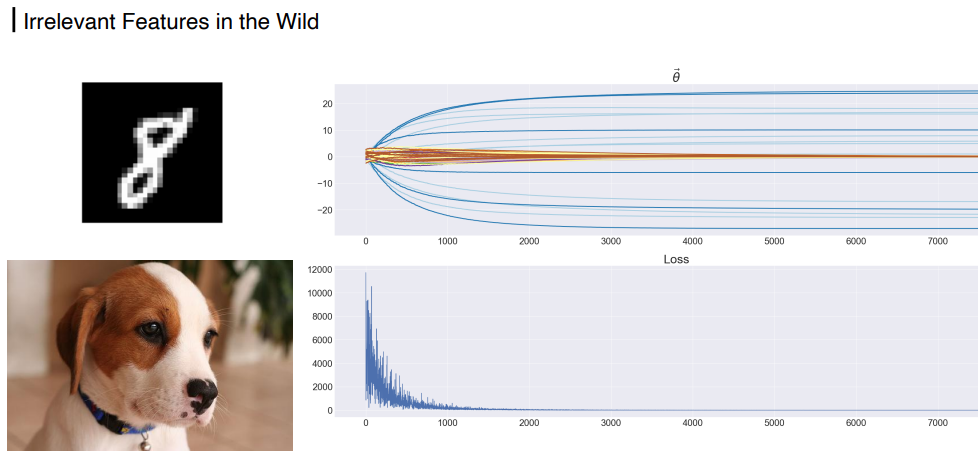

# MVLR for Discrete Features

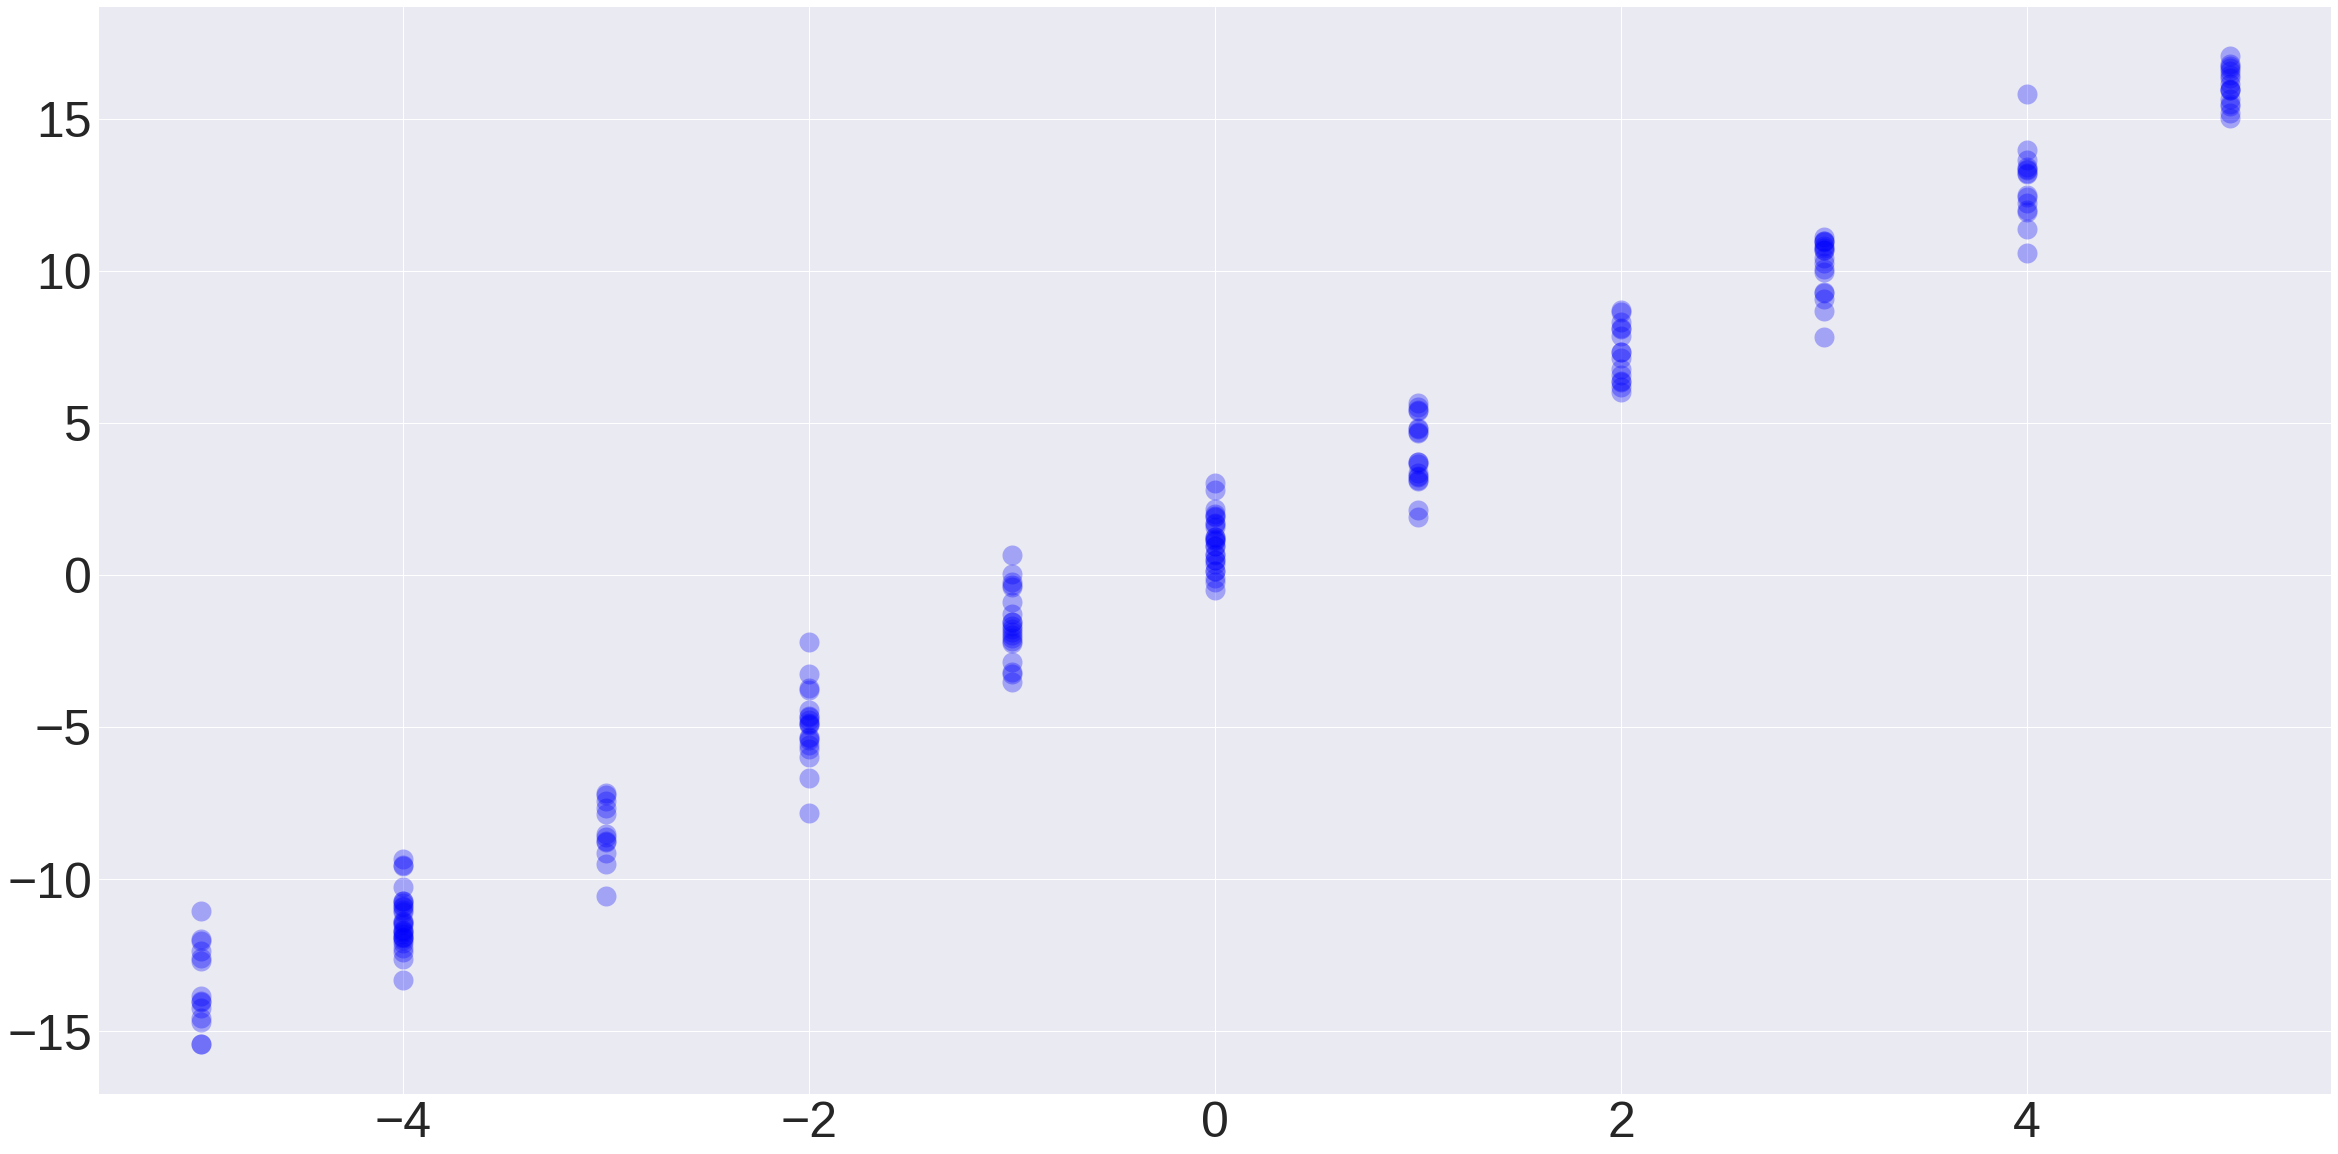

In [18]:
n_sample = 200
x_data1 = np.random.randint(-5, 6, size=(n_sample, 1))
y_data = 3*x_data1 + 1 + np.random.normal(0,1,size=(n_sample,1))

fig,ax = plt.subplots(figsize=(40,20))
ax.plot(x_data1, y_data, 'bo', markersize=20, alpha=0.3)
ax.tick_params(axis='both', labelsize=50)

In [21]:
x_data = np.zeros(shape=(n_sample,1))
x_data = np.hstack((x_data, x_data1))
data = np.hstack((x_data, y_data))

batch_size = 8
n_batch = np.ceil(data.shape[0]/batch_size).astype(int)
feature_dim = x_data.shape[1] - 1
Th = np.array([-1.,-4.]).reshape(-1,1)
epochs, lr = 10, 0.01

th_accum = Th.reshape(-1,1)
cost_list = []

affine = Affine_Function(feature_dim ,Th)
cost = MSE_Cost()

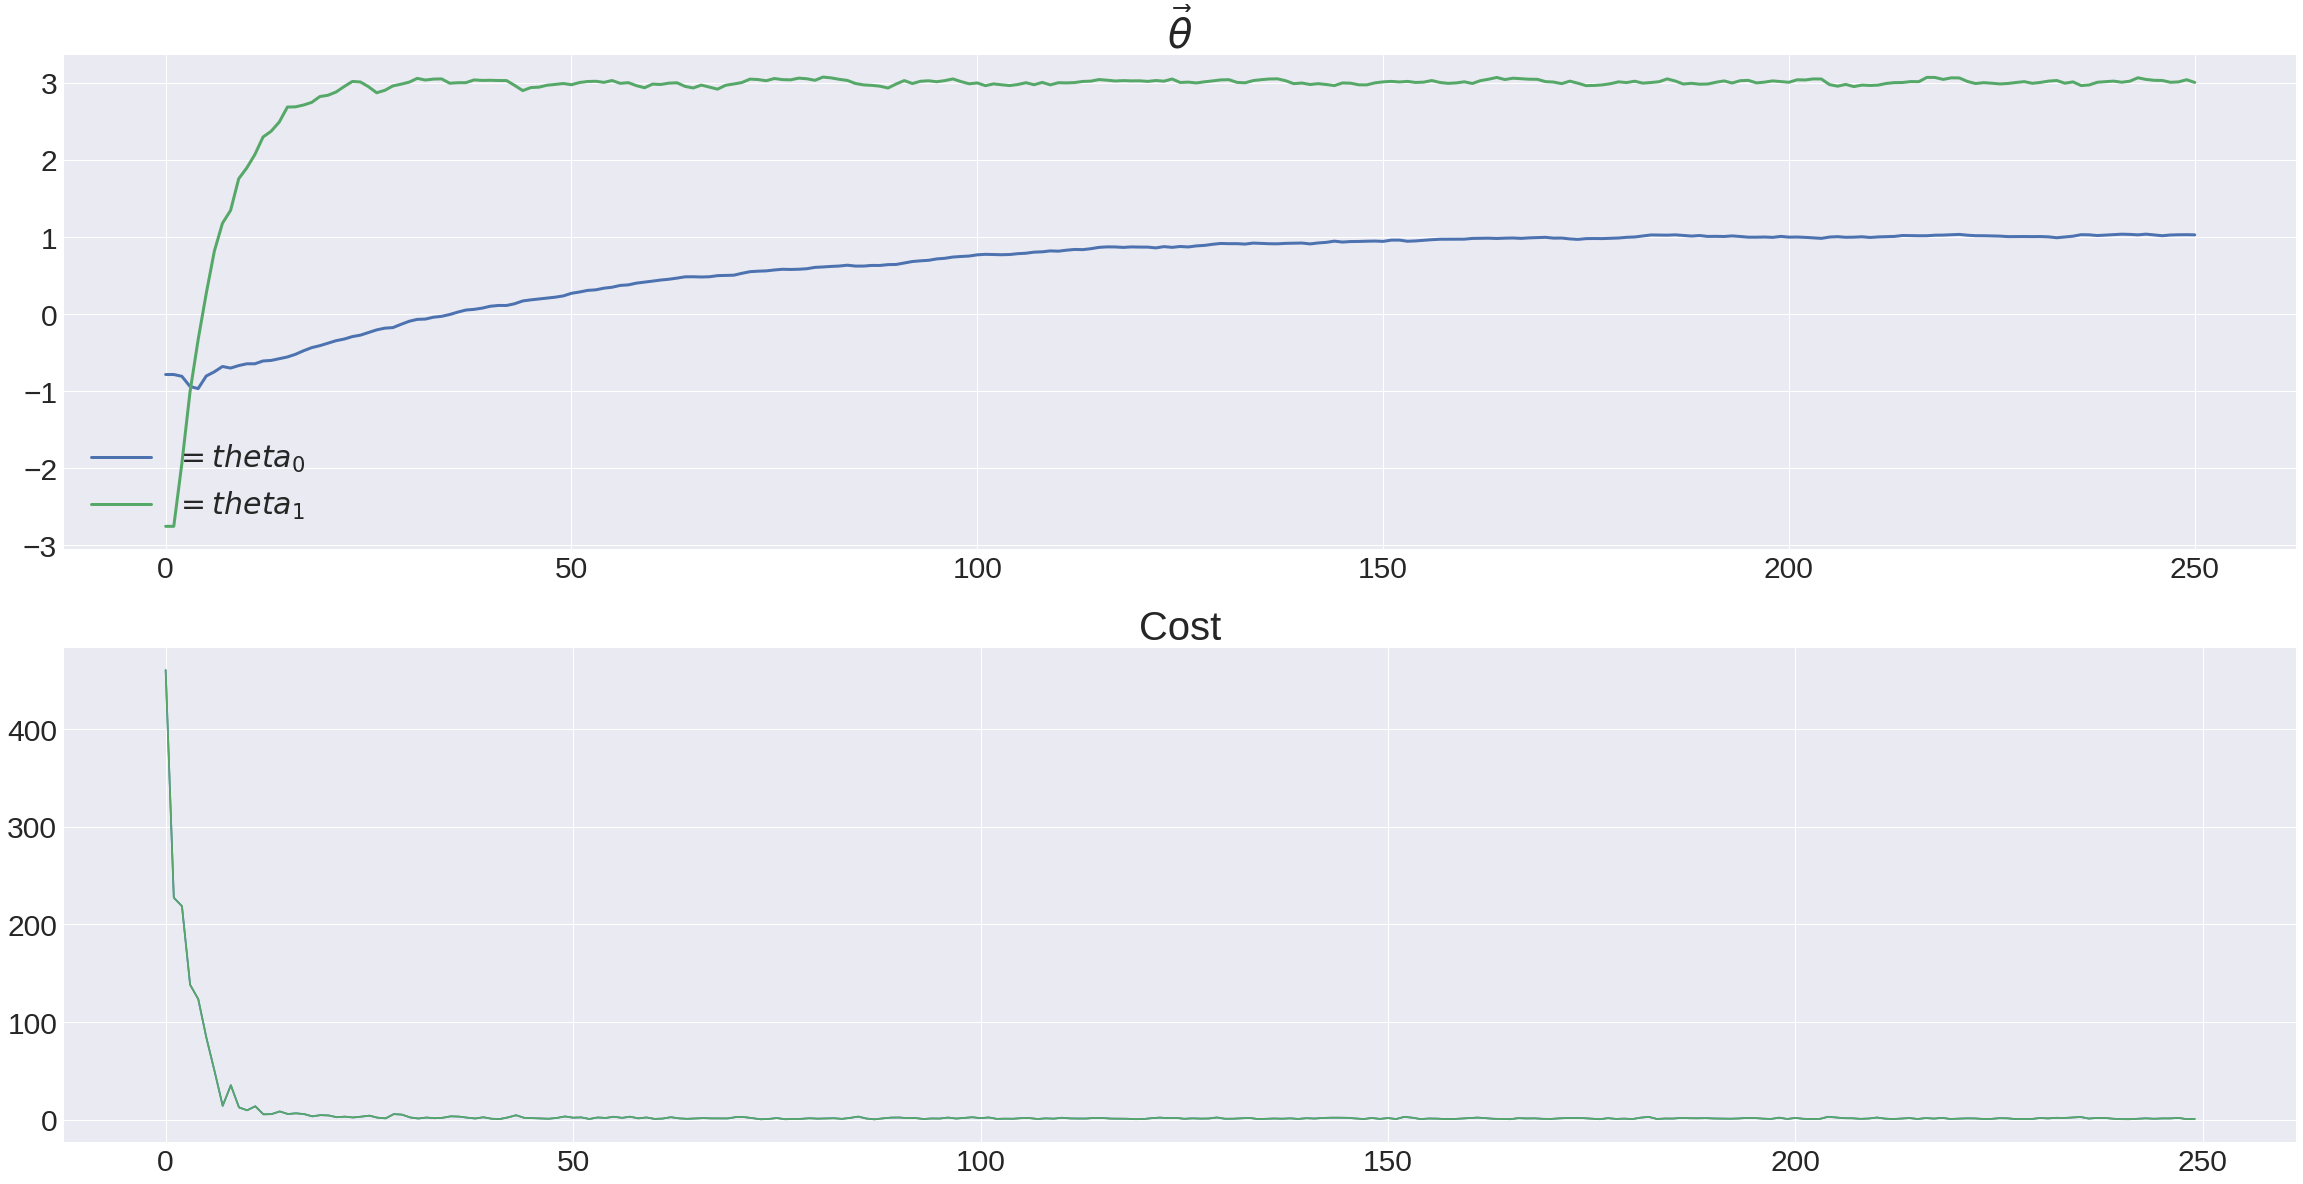

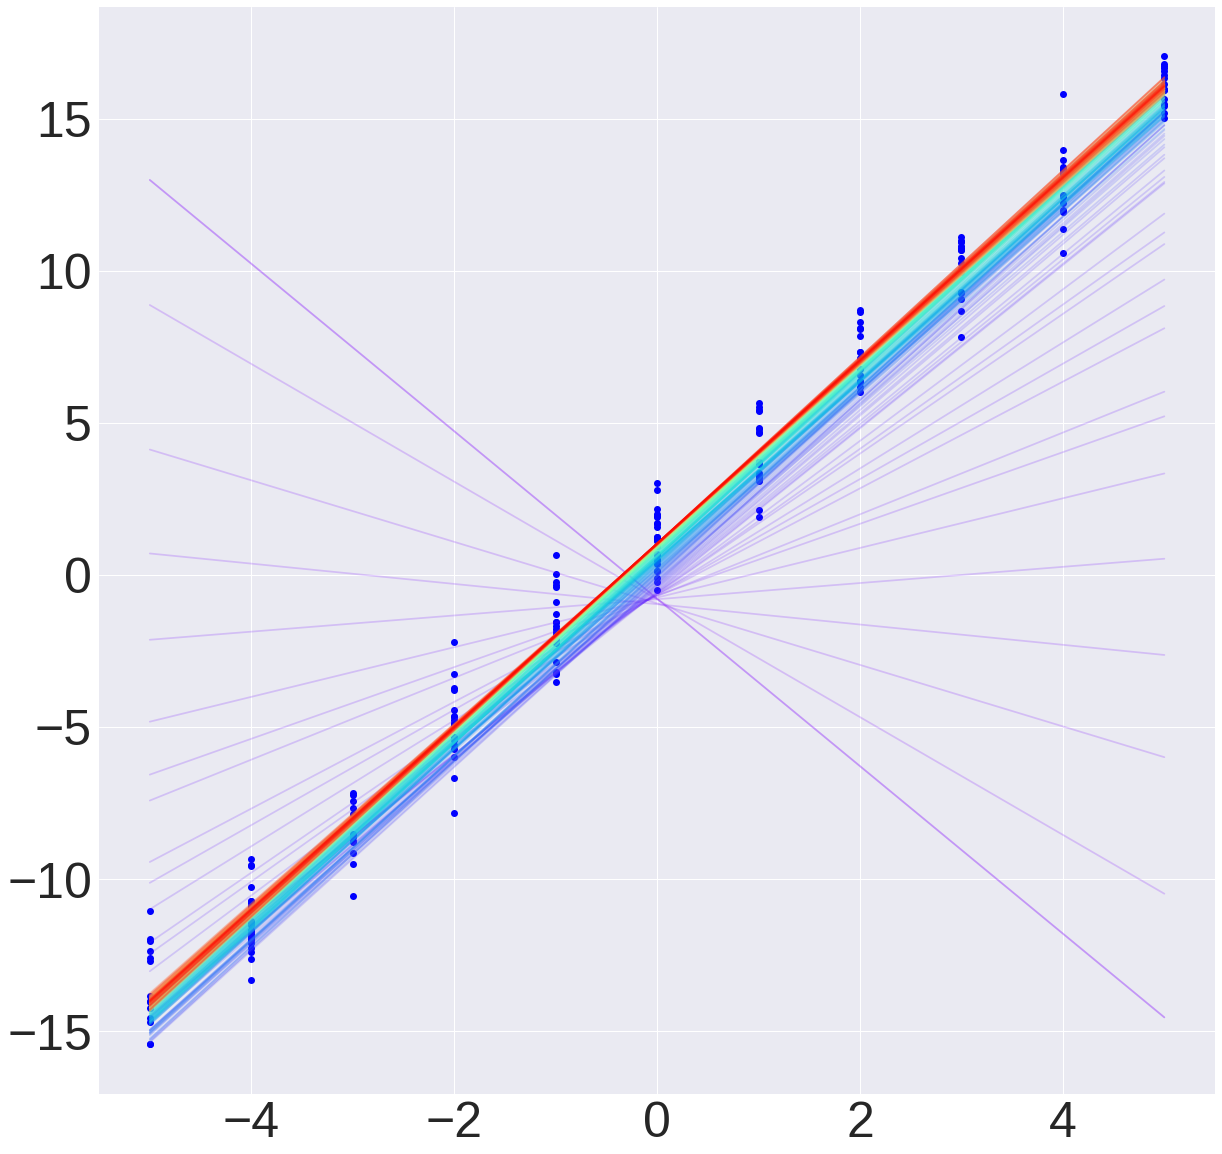

In [22]:
for epoch in range(epochs):
  np.random.shuffle(data)

  for batch_idx in range(n_batch):
    batch = get_data_batch(data, batch_idx)
    X, Y = batch[:,:-1], batch[:,-1]

    Pred = affine.forward(X)
    J = cost.forward(Y,Pred)

    dPred = cost.backward()
    affine.backward(dPred, lr)

    th_accum = np.hstack((th_accum, affine._Th))
    cost_list.append(J)

# visualization
fig,ax = plt.subplots(2,1, figsize=(40,20))
for th_idx in range(feature_dim + 1):
  ax[0].plot(th_accum[th_idx],
             label = r'$=theta_{%d}$'%th_idx,
             linewidth = 3)
  ax[1].plot(cost_list)

  ax[0].legend(loc = 'lower left',
               fontsize=30)
  ax[0].tick_params(axis='both', labelsize=30)
  ax[1].tick_params(axis='both', labelsize=30)

  ax[0].set_title(r'$\vec{\theta}$', fontsize=40)
  ax[1].set_title('Cost', fontsize=40)

fig,ax = plt.subplots(figsize=(20,20))
ax.plot(x_data1, y_data, 'bo')

cmap = cm.get_cmap('rainbow', lut = th_accum.shape[1])

x_range = np.array([np.min(x_data1), np.max(x_data1)])
for th_idx in range(th_accum.shape[1]):
  th1, th0 = th_accum[1,th_idx], th_accum[0,th_idx]

  pred = th1*x_range + th0

  ax.plot(x_range, pred, color=cmap(th_idx), alpha=0.2)
ax.tick_params(axis='both', labelsize=50)